# Les publications dans HAL de l'UL2, issues des financements de l'ANR

 ###  <span style="color:red" > Université Lumière Lyon 2 </span>
 
 ####  <span style="color:orange" > *Février 2023* </span>

- Le notebook décrit les différentes étapes d'extraction des publications de HAL
- On extrait les publications dans HAL(tous types) de l'Université Lyon 2 issues des financements de l'ANR¶
- On calcul le taux d'ouverture global pour ces documents ainsi que le taux d'ouverture par laboratoires.

In [48]:
import requests, json, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
import seaborn as sns

## <span style="color:black" > 1 Les données </span>

In [5]:
req = requests.get('https://api.archives-ouvertes.fr/search/?q=structId_i:33804&fq=anrProject_t:["" TO *]&rows=20000\
&fl=publicationDateY_i,docType_s,title_s,doiId_s,domainAllCode_s,\
domain_s,domain_t,primaryDomain_s,journalTitle_s, journalPublisher_s,journalIssn_s,language_s,instStructName_s,\
                     instStructId_i,instStructAcronym_s,anrProjectYearDate_s,anrProjectTitle_s,anrProjectTitle_t\
                      anrProjectTitleId_fs,anrProjectReference_t,anrProjectId_i,anrProjectCallTitle_s\
                      anrProjectCallAcronym_s,anrProjectAcronym_s,openAccess_bool,labStructAcronym_s,labStructName_s,\
                      labStructId_i')
req_json = req.json()
anr_hal_lyon2_liste = req_json["response"]['docs']

In [6]:
anr_hal_lyon2 = pd.DataFrame(anr_hal_lyon2_liste)
anr_hal_lyon2 = anr_hal_lyon2.sort_values("publicationDateY_i", ascending = False)
anr_hal_lyon2.shape

(2728, 25)

In [96]:
##### Au 4 février 2023 il y a 2728 documents issus de projets ANR de l'Université Lyon 2 déposés dans HAL

In [7]:
anr_hal_lyon2.isnull().sum()

openAccess_bool               0
domainAllCode_s               4
domain_s                      4
primaryDomain_s               0
title_s                       0
journalTitle_s             1892
journalPublisher_s         1927
journalIssn_s              1989
anrProjectId_i                0
anrProjectTitle_s             6
anrProjectAcronym_s           0
anrProjectCallTitle_s      1505
anrProjectCallAcronym_s       1
anrProjectYearDate_s          1
anrProjectTitleId_fs          0
labStructId_i                 2
labStructAcronym_s            3
labStructName_s               2
instStructId_i                0
instStructAcronym_s           0
instStructName_s              0
language_s                    0
docType_s                     0
publicationDateY_i            0
doiId_s                    2027
dtype: int64

**Je retire les publications sans identifiants labo `labStructId_i`**

In [8]:
anr_hal_lyon2_labo = anr_hal_lyon2.dropna(subset='labStructId_i')
anr_hal_lyon2_labo.shape

(2726, 25)

In [9]:
anr_hal_lyon2_labo.head(2)

,openAccess_bool,domainAllCode_s,domain_s,primaryDomain_s,title_s,journalTitle_s,journalPublisher_s,journalIssn_s,anrProjectId_i,anrProjectTitle_s,anrProjectAcronym_s,anrProjectCallTitle_s,anrProjectCallAcronym_s,anrProjectYearDate_s,anrProjectTitleId_fs,labStructId_i,labStructAcronym_s,labStructName_s,instStructId_i,instStructAcronym_s,instStructName_s,language_s,docType_s,publicationDateY_i,doiId_s
2001,False,[shs.langue],"[0.shs, 1.shs.langue]",shs.langue,"[Loïc Lantoine, chanteur pas engagé]",NaN,NaN,NaN,[49753],[Advanced Studies on Language Complexity],[ASLAN],NaN,[LABX],[2010],[Advanced Studies on Language Complexity_Facet...,[51028],[ICAR],"[Interactions, Corpus, Apprentissages, Représe...","[6818, 33804, 300042, 303652, 441569]","[ENS Lyon, UL2, ENS LSH, CNRS]","[École normale supérieure - Lyon, Université L...",[fr],COUV,2023,NaN
699,True,[shs],[0.shs],shs,[The Hidden Energies of Work Digitisation: A V...,NaN,NaN,NaN,[43284],[Durabilités et spatialités des pratiques de m...,[COWORKWORLDS],NaN,[AAPG2017],[2017],[Durabilités et spatialités des pratiques de m...,"[447425, 1043180]","[LAET, PACTE]","[Laboratoire Aménagement Économie Transports, ...","[33804, 300365, 441569, 441569, 1043359]","[UL2, ENTPE, CNRS, CNRS, IEPG]","[Université Lumière - Lyon 2, École Nationale ...",[en],COUV,2023,10.1007/978-3-031-16708-9_7


**Je selectionne les variables dont les valeurs n'ont pas de crochets, parmi les variables d'intérêt**

In [10]:
x = ['openAccess_bool', 'primaryDomain_s', 'journalTitle_s', 'journalPublisher_s', 'journalIssn_s', 'docType_s', \
     'publicationDateY_i', 'doiId_s']

In [11]:
anr_hal_lyon2_labo_2 = anr_hal_lyon2_labo[x]

**Je retire les crochets des valeurs des variables d'intérêt**

In [12]:
### Variables de type charactère
dom_all = anr_hal_lyon2_labo["domainAllCode_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
dom = anr_hal_lyon2_labo["domain_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
titre = anr_hal_lyon2_labo["title_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
anr_titre = anr_hal_lyon2_labo["anrProjectTitle_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
anr_sigle = anr_hal_lyon2_labo["anrProjectAcronym_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
labo_sigle = anr_hal_lyon2_labo["labStructAcronym_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
labo_nom = anr_hal_lyon2_labo["labStructName_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
institution_sigle = anr_hal_lyon2_labo["instStructAcronym_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
institution_nom = anr_hal_lyon2_labo["instStructName_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
doc_langue = anr_hal_lyon2_labo["language_s"].apply(lambda x: ",".join(x) if isinstance(x, list) else x)

### Variables de type objet
anr_id = anr_hal_lyon2_labo["anrProjectId_i"].apply(lambda x: ",".join(map(str,x)) if isinstance(x, list) else x)
labo_id = anr_hal_lyon2_labo["labStructId_i"].apply(lambda x: ",".join(map(str,x)) if isinstance(x, list) else x)
institution_id = anr_hal_lyon2_labo["instStructId_i"].apply(lambda x: ",".join(map(str,x)) if isinstance(x, list) else x)

In [13]:
### Dataframe
dom_all_df = pd.DataFrame(dom_all)
dom_df = pd.DataFrame(dom)
titre_df = pd.DataFrame(titre)
anr_titre_df = pd.DataFrame(anr_titre)
anr_sigle_df = pd.DataFrame(anr_sigle)
labo_sigle_df = pd.DataFrame(labo_sigle)
labo_nom_df = pd.DataFrame(labo_nom)
institution_sigle_df = pd.DataFrame(institution_sigle)
institution_nom_df = pd.DataFrame(institution_nom)
doc_langue_df = pd.DataFrame(doc_langue)
anr_id_df = pd.DataFrame(anr_id)
labo_id_df = pd.DataFrame(labo_id)
institution_id_df = pd.DataFrame(institution_id)

In [14]:
### Concaténation
frames = [anr_hal_lyon2_labo_2, dom_all_df, dom_df, titre_df,
                                   anr_titre_df,anr_sigle_df,labo_sigle_df,labo_nom_df,
                                   institution_sigle_df,institution_nom_df,doc_langue_df,
                                   anr_id_df,labo_id_df,institution_id_df]
anr_hal_lyon2_labo_full = pd.concat(frames, axis=1)
anr_hal_lyon2_labo_full.head(2)

,openAccess_bool,primaryDomain_s,journalTitle_s,journalPublisher_s,journalIssn_s,docType_s,publicationDateY_i,doiId_s,domainAllCode_s,domain_s,title_s,anrProjectTitle_s,anrProjectAcronym_s,labStructAcronym_s,labStructName_s,instStructAcronym_s,instStructName_s,language_s,anrProjectId_i,labStructId_i,instStructId_i
2001,False,shs.langue,NaN,NaN,NaN,COUV,2023,NaN,shs.langue,"0.shs,1.shs.langue","Loïc Lantoine, chanteur pas engagé",Advanced Studies on Language Complexity,ASLAN,ICAR,"Interactions, Corpus, Apprentissages, Représen...","ENS Lyon,UL2,ENS LSH,CNRS","École normale supérieure - Lyon,Université Lum...",fr,49753,51028,"6818,33804,300042,303652,441569"
699,True,shs,NaN,NaN,NaN,COUV,2023,10.1007/978-3-031-16708-9_7,shs,0.shs,The Hidden Energies of Work Digitisation: A Vi...,Durabilités et spatialités des pratiques de mo...,COWORKWORLDS,"LAET,PACTE","Laboratoire Aménagement Économie Transports,Pa...","UL2,ENTPE,CNRS,CNRS,IEPG","Université Lumière - Lyon 2,École Nationale de...",en,43284,"447425,1043180","33804,300365,441569,441569,1043359"


In [15]:
anr_hal_lyon2_labo_full.shape

(2726, 21)

## <span style="color:black" > 2 Taux d'ouverture global des publications des projets ANR </span>

In [16]:
s = anr_hal_lyon2_labo_full.openAccess_bool
s

2001    False
699      True
322      True
1878    False
954      True
        ...  
1413     True
2657     True
66      False
632      True
2183    False
Name: openAccess_bool, Length: 2726, dtype: bool

In [17]:
counts = s.value_counts()
counts

False    1631
True     1095
Name: openAccess_bool, dtype: int64

In [18]:
percent = s.value_counts(normalize=True)
percent

False    0.598313
True     0.401687
Name: openAccess_bool, dtype: float64

In [20]:
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent100

False    59.8%
True     40.2%
Name: openAccess_bool, dtype: object

In [21]:
tableau = pd.DataFrame({'Total': counts, 'Fréquence': percent, 'Pourcentage': percent100})
tableau

,Total,Fréquence,Pourcentage
False,1631,0.598313,59.8%
True,1095,0.401687,40.2%


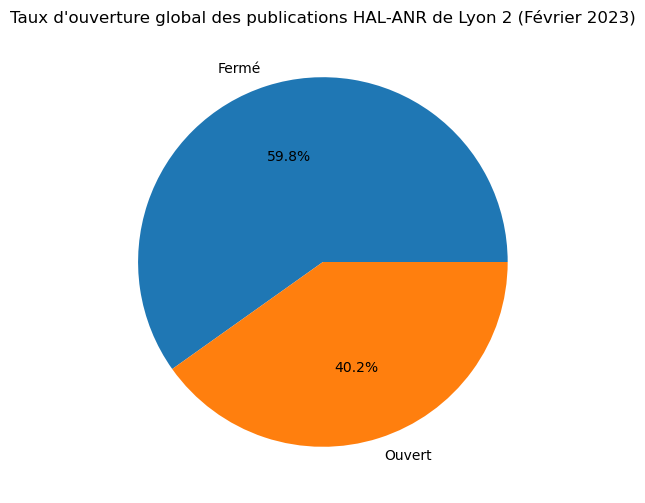

In [54]:
plot1 = tableau['Total'].plot.pie(
labels=["Fermé", "Ouvert"],
    autopct="%.1f%%",
     fontsize=10,
    figsize=(6, 6),
    title="Taux d'ouverture global des publications HAL-ANR de Lyon 2 (Février 2023)", ylabel=''
  );

## <span style="color:black" > 3 Taux d'ouverture des publications des projets ANR par laboratoires </span>

In [23]:
# Les laboratoires
Labo = ['619','444290','3131','1062481','146317','136794','88676','102810','191786','740','528282','145304','214341','70904',
'2562','183072','145345','102550','49955','670','567','51028','1063691','102816','498032','447425','1043116','89915',
'102818','2003','145356','145357']

In [24]:
data_per_labo = []
for i in Labo:
    table = anr_hal_lyon2_labo_full[anr_hal_lyon2_labo_full["labStructId_i"].str.contains(i)].assign(id = i)  
    data_per_labo.append(table)
full_data = pd.concat(data_per_labo)

In [25]:
full_data.shape

(2378, 22)

In [26]:
#### Vérification ...
lab = ['145357']
filtre_lab = full_data[full_data['id'].isin(lab)]
filtre_lab.shape

(109, 22)

In [27]:
#### ... identique à: (# Il y a 109 documents pour le laboratoire Triangle (labStructId_i = "145357"))
Triangle = anr_hal_lyon2_labo_full["labStructId_i"].str.contains('145357')
Triangle.value_counts()

False    2617
True      109
Name: labStructId_i, dtype: int64

In [28]:
full_data.head(2)

,openAccess_bool,primaryDomain_s,journalTitle_s,journalPublisher_s,journalIssn_s,docType_s,publicationDateY_i,doiId_s,domainAllCode_s,domain_s,title_s,anrProjectTitle_s,anrProjectAcronym_s,labStructAcronym_s,labStructName_s,instStructAcronym_s,instStructName_s,language_s,anrProjectId_i,labStructId_i,instStructId_i,id
1021,False,shs.archeo,Proceedings of the Seminar for Arabian Studies,Archaeopress,0308-8421,PROCEEDINGS,2022,NaN,shs.archeo,"0.shs,1.shs.archeo",The Camel Site reliefs — an investigation of t...,Religions and Societies in the Mediterranean W...,RESMED,"OM,OM,Archéorient","ORIENT ET MÉDITERRANÉE : Textes, Archéologie, ...","UP1,EPHE,CdF (institution),CNRS,UP1,EPHE,CdF (...","Max-Planck-Gesellschaft,Université Paris 1 Pan...",en,24812,"542221,542221,1084285,234571,619","5247,7550,110691,300026,441569,7550,110691,300...",619
1762,False,shs.archeo,Journal of Island and Coastal Archaeology,Taylor & Francis,1556-4894,ART,2022,10.1080/15564894.2021.2015017,shs.archeo,"0.shs,1.shs.archeo",The latest Neolithic conquest of &quot;new ter...,Analyse de la durabilité et des réorganisation...,NeoArabia,"ArScAn,CReAAH,AASPE,Archéorient","Archéologies et Sciences de l'Antiquité,Centre...","UP1,UP8,UPN,MCC,Inrap,CNRS,UM,UR1,UR2,CNRS,MC,...","Université Paris 1 Panthéon-Sorbonne,Universit...",en,43981,"1003,1089201,118105,619","7550,11141,116205,300125,301475,441569,7566,10...",619


In [29]:
## Vérification que je peux avoir des publications avec le même index, c'est ok, une publication
## en collaboration entre plusieurs labo est comptée une fois par labo
df1 = full_data[full_data.index==282]
df1

,openAccess_bool,primaryDomain_s,journalTitle_s,journalPublisher_s,journalIssn_s,docType_s,publicationDateY_i,doiId_s,domainAllCode_s,domain_s,title_s,anrProjectTitle_s,anrProjectAcronym_s,labStructAcronym_s,labStructName_s,instStructAcronym_s,instStructName_s,language_s,anrProjectId_i,labStructId_i,instStructId_i,id
282,False,sdu.envi,Review of Palaeobotany and Palynology,Elsevier,0034-6667,ART,2022,10.1016/j.revpalbo.2022.104713,"sdu.envi,sde.mcg","0.sdu,1.sdu.envi,0.sde,1.sde.mcg",First pollen record from the Late Holocene for...,Labex OT-MED,OT-MED,"UMR ISEM,UMR ISEM,LAMPEA,CEREGE,LEHNA,LGL-TPE,...",Institut des Sciences de l'Evolution de Montpe...,"Cirad,EPHE,UM,CNRS,Cirad,EPHE,CNRS,AMU,CNRS,MC...",Centre de Coopération Internationale en Recher...,en,59223,"29770,1100670,208163,1002357,215697,153787,670...","11574,110691,410122,431575,441569,11574,110691...",619
282,False,sdu.envi,Review of Palaeobotany and Palynology,Elsevier,0034-6667,ART,2022,10.1016/j.revpalbo.2022.104713,"sdu.envi,sde.mcg","0.sdu,1.sdu.envi,0.sde,1.sde.mcg",First pollen record from the Late Holocene for...,Labex OT-MED,OT-MED,"UMR ISEM,UMR ISEM,LAMPEA,CEREGE,LEHNA,LGL-TPE,...",Institut des Sciences de l'Evolution de Montpe...,"Cirad,EPHE,UM,CNRS,Cirad,EPHE,CNRS,AMU,CNRS,MC...",Centre de Coopération Internationale en Recher...,en,59223,"29770,1100670,208163,1002357,215697,153787,670...","11574,110691,410122,431575,441569,11574,110691...",670


In [30]:
group = full_data.groupby(['id','openAccess_bool'])['title_s'].count()

In [31]:
tableau2 = pd.DataFrame({'Total': group})

In [32]:
tableau2['%'] = 100 * tableau2['Total'] / tableau2.groupby('id')['Total'].transform('sum')
tableau3 = tableau2.reset_index()
tableau3.head(10)

,id,openAccess_bool,Total,%
0,102550,False,8,17.021277
1,102550,True,39,82.978723
2,102810,False,3,75.000000
3,102810,True,1,25.000000
4,102816,False,4,25.000000
5,102816,True,12,75.000000
6,102818,False,1,20.000000
7,102818,True,4,80.000000
8,1043116,False,22,95.652174
9,1043116,True,1,4.347826


In [33]:
tableau3['openAccess_bool'] = tableau3['openAccess_bool'].replace('False','Fermé')
tableau3['openAccess_bool'] = tableau3['openAccess_bool'].replace('True','Ouvert')
tableau3.head(2)

,id,openAccess_bool,Total,%
0,102550,False,8,17.021277
1,102550,True,39,82.978723


In [34]:
tableau4 = pd.DataFrame({'id': ['619','444290','3131','1062481','146317','136794','88676','102810','191786','740','528282','145304','214341','70904',
'2562','183072','145345','102550','49955','670','567','51028','1063691','102816','498032','447425','1043116','89915',
'102818','2003','145356','145357'],
                    'Laboratoire': ['ARCHÉORIENT','ArAr','CERCRID','CERLA','CIHAM','CMW','COACTIS','CRPPC','DCT','DDL','DIPHE','DISP',
'ECP','ELICO','EMC','ERIC','EVS','GATE','GRePS','HISOMA','IAO','ICAR','IHRIM','IRAA','LADEC','LAET','LARHRA',
'LCE','LER','LIRIS','XXI','Triangle' ]})
tableau4.head(5)

,id,Laboratoire
0,619,ARCHÉORIENT
1,444290,ArAr
2,3131,CERCRID
3,1062481,CERLA
4,146317,CIHAM


In [35]:
tableau5 = pd.merge(tableau3, 
                     tableau4, 
                     on ='id', 
                     how ='left')
tableau5.head(5)

,id,openAccess_bool,Total,%,Laboratoire
0,102550,False,8,17.021277,GATE
1,102550,True,39,82.978723,GATE
2,102810,False,3,75.000000,CRPPC
3,102810,True,1,25.000000,CRPPC
4,102816,False,4,25.000000,IRAA


In [36]:
tableau6 = tableau5.pivot_table('Total', index = 'Laboratoire', aggfunc=sum)
tableau7 = tableau6.reset_index()
tableau7.head(5)

,Laboratoire,Total
0,ARCHÉORIENT,89
1,ArAr,31
2,CERCRID,9
3,CERLA,1
4,CIHAM,91


In [37]:
tableau8 = tableau5[tableau5['openAccess_bool'] == True]
tableau8.head(5)

,id,openAccess_bool,Total,%,Laboratoire
1,102550,True,39,82.978723,GATE
3,102810,True,1,25.000000,CRPPC
5,102816,True,12,75.000000,IRAA
7,102818,True,4,80.000000,LER
9,1043116,True,1,4.347826,LARHRA


In [39]:
tableau9 = tableau8.drop(columns=['id','openAccess_bool', 'Total']).rename(columns={"%": "Pourcentage d'ouverture"})
tableau9.head(5)

,Pourcentage d'ouverture,Laboratoire
1,82.978723,GATE
3,25.000000,CRPPC
5,75.000000,IRAA
7,80.000000,LER
9,4.347826,LARHRA


In [40]:
tableau_final = pd.merge(tableau7, 
                     tableau9, 
                     on ='Laboratoire', 
                     how ='left')

In [42]:
tableau_final.fillna(0).rename(columns={"Total": "Total des documents HAL"})

,Laboratoire,Total des documents HAL,Pourcentage d'ouverture
0,ARCHÉORIENT,89,32.584270
1,ArAr,31,32.258065
2,CERCRID,9,55.555556
3,CERLA,1,0.000000
4,CIHAM,91,20.879121
5,CMW,114,23.684211
6,COACTIS,17,47.058824
7,CRPPC,4,25.000000
8,DCT,1,0.000000
9,DDL,139,43.884892


In [43]:
tableau_final.dtypes

Laboratoire                 object
Total                        int64
Pourcentage d'ouverture    float64
dtype: object

In [44]:
tableau_final_bis = tableau_final.drop(columns=['Total'])

<Figure size 32000x30400 with 0 Axes>

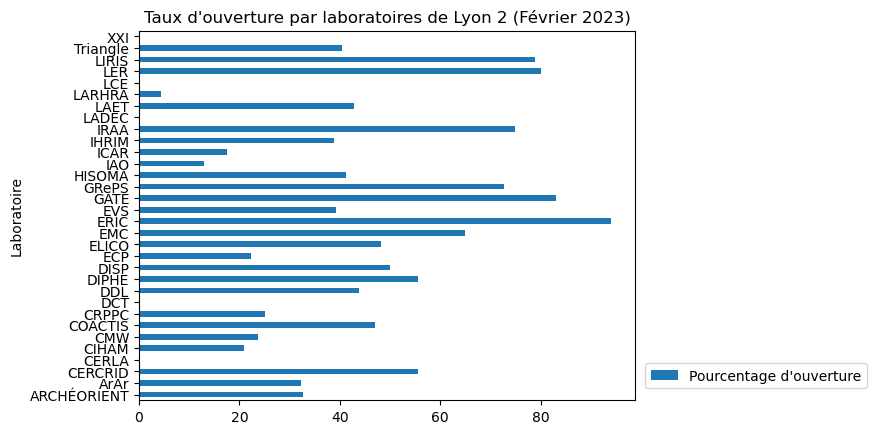

In [45]:
from matplotlib.pyplot import figure

figure(figsize=(40, 38), dpi=800)

plot2 = tableau_final_bis.plot(
    x = 'Laboratoire',
    kind = 'barh',
    stacked = True,
    title = "Taux d'ouverture par laboratoires de Lyon 2 (Février 2023)",
    mark_right = False)
#place legend in center right of plot
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)

In [53]:
fig1 = plot1.get_figure()
fig1.savefig('plot_1.png', dpi=400)

In [47]:
fig2 = plot2.get_figure()
fig2.savefig('plot_2.png', dpi=400)